In [1]:
import h5py
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy import stats
import sys
from statsmodels.formula.api import mixedlm
import glob
import re

sys.path.append('../utils')
from plotting import hide_spines, plot_stars
from protocols import load_params
from db import get_db_info, select_db
sys.path.append('../neural_analysis')
from analysis_by_class import plot_stars_mouse_by_class

/home/adam/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Distribution decoding on single trials
## Generate Fig. 4f

In [8]:
plt.style.use('paper_export')
protocol = 'SameRewDist'
class_name = 'helper'
class_labels = ['all']

neural_path = '../../data/SameRewDist_combined_spks_data_20230918.p'
cutoff = 73


In [5]:
with open(neural_path, 'rb') as f:
    info = pickle.load(f)

In [6]:
neuron_info = pd.DataFrame(info['neuron_info'])
neuron_info

,names,file_dates,cluster_id,neuron_idx_good,neuron_idx_inc,fig_paths,depths,aps,mls,regions,...,null_93,cutoff_95,null_95,cutoff_97,null_97,risk_index,favored_bin,direction,session_ids,mouse_ids
0,AL39,20210930,0,0,0,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.629776,0.506758,-1.272312,ACB,...,False,False,False,False,False,0.775748,0,Neutral,0,0
1,AL39,20210930,2,2,1,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.554798,0.505883,-1.273910,ACB,...,False,False,False,False,False,0.302602,6,Positive,0,0
2,AL39,20210930,3,3,2,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.524807,0.505576,-1.274558,ACB,...,False,True,False,True,False,NaN,2,Neutral,0,0
3,AL39,20210930,5,5,3,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.449827,0.505116,-1.276246,ACB,...,False,False,False,False,False,0.362003,6,Positive,0,0
4,AL39,20210930,8,7,5,/n/holystore01/LABS/uchida_users/Users/alowet/...,-5.404840,0.504840,-1.277259,ACB,...,False,False,False,False,False,-0.359181,4,Positive,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13992,AL83,20220915,1103,653,288,/n/holystore01/LABS/uchida_users/Users/alowet/...,-2.770189,0.976379,-1.657884,CP,...,False,False,False,False,False,NaN,2,Neutral,70,11
13993,AL83,20220915,1104,654,289,/n/holystore01/LABS/uchida_users/Users/alowet/...,-2.770189,0.976379,-1.657884,CP,...,False,False,False,False,False,-0.187390,0,Negative,70,11
13994,AL83,20220915,1113,656,290,/n/holystore01/LABS/uchida_users/Users/alowet/...,-2.750189,0.976328,-1.657799,CP,...,False,False,False,False,False,-2.195132,0,Neutral,70,11
13995,AL83,20220915,1116,658,292,/n/holystore01/LABS/uchida_users/Users/alowet/...,-2.710190,0.976225,-1.657629,CP,...,False,False,False,False,False,-2.210595,0,Neutral,70,11


In [10]:
# this method ensures the same color mapping across lesion and helper
paths = get_db_info()
mice_rets = select_db(paths['db'], 'session', 'name', 'protocol=? AND has_ephys=1 AND significance=1', (protocol,), unique=False)
all_mice = sorted(np.unique([ret['name'] for ret in mice_rets]))
cset = 'Set3'

color_set = mpl.cm.get_cmap(cset).colors
mouse_colors = {k: v for k, v in zip(all_mice, color_set)}
mouse_names = np.unique(neuron_info['names'])

/home/adam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/adam/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        diff     
No. Observations:          62             Method:                    REML     
No. Groups:                12             Scale:                     8.8983   
Min. group size:           3              Log-Likelihood:            -141.0705
Max. group size:           8              Converged:                 Yes      
Mean group size:           5.2                                                
------------------------------------------------------------------------------
                 Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept       1.125e+01 8.611e-01  1.307e+01 5.143e-39  9.564e+00  1.294e+01
C(lAcbSh)[T.0]  1.327e+00 1.387e+00  9.565e-01 3.388e-01 -1.392e+00  4.045e+00
C(lAcbSh)[T.1] -1.579e+00 1.477e+00 -1.069e+00 2.851e-01 -4.473e+00  1.31

/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       diff     
No. Observations:        62            Method:                   REML     
No. Groups:              12            Scale:                    8.8983   
Min. group size:         3             Log-Likelihood:           -141.0705
Max. group size:         8             Converged:                Yes      
Mean group size:         5.2                                              
--------------------------------------------------------------------------
             Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------
Intercept   1.258e+01 1.087e+00  1.157e+01 6.068e-31  1.045e+01  1.471e+01
C(OT)[T.1] -2.905e+00 1.657e+00 -1.753e+00 7.959e-02 -6.154e+00  3.428e-01
C(OT)[T.2] -3.536e+00 3.188e+00 -1.109e+00 2.674e-01 -9.784e+00  2.712e+00
C(OT)[T.3] -1.327e+00 1.387e+00 -9.565e-01 3

/home/adam/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/adam/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/adam/

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        cutoff_73
No. Observations:          62             Method:                    REML     
No. Groups:                12             Scale:                     9.6763   
Min. group size:           3              Log-Likelihood:            -143.2916
Max. group size:           8              Converged:                 Yes      
Mean group size:           5.2                                                
------------------------------------------------------------------------------
                 Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept       1.447e+01 8.980e-01  1.611e+01 2.190e-58  1.271e+01  1.623e+01
C(lAcbSh)[T.0]  8.347e-01 1.441e+00  5.793e-01 5.624e-01 -1.990e+00  3.659e+00
C(lAcbSh)[T.1] -2.257e+00 1.554e+00 -1.453e+00 1.464e-01 -5.303e+00  7.88

/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


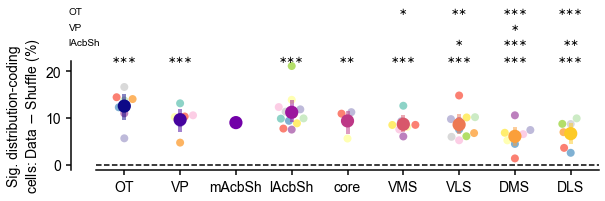

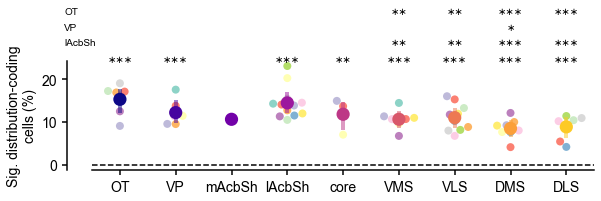

In [12]:
cut_key = 'cutoff_' + str(cutoff)
null_key = 'null_' + str(cutoff)
min_size = 40
rel_classes = ['lAcbSh', 'VP', 'OT']
reg_labels = ['OT', 'VP', 'mAcbSh', 'lAcbSh', 'core', 'VMS', 'VLS', 'DMS', 'DLS']
rois = reg_labels + ['All Subregions']
dv_palette = [plt.cm.plasma(i / (len(rois) - 1)) for i in range(len(rois))]

reg_df = neuron_info.loc[np.isin(neuron_info['str_regions'], reg_labels), ['names', 'str_regions', cut_key, null_key]]
count_df = reg_df.groupby(['names', 'str_regions'], as_index=False).count().sort_values(by=['names', 'str_regions'])
dist_cell_df = reg_df.groupby(['names', 'str_regions'], as_index=False).agg({cut_key: 'mean', null_key: 'mean'})
dist_cell_df[[cut_key, null_key]] *= 100
dist_cell_df['diff'] = (dist_cell_df[cut_key] - dist_cell_df[null_key])
dist_cell_df = dist_cell_df[count_df[cut_key] > min_size]

dist_cell_df[rel_classes] = 0
# print(dist_cell_df)

for index, row in dist_cell_df.iterrows():
    dist_cell_df.at[index, rel_classes] = reg_labels.index(row['str_regions'])    
for rel_class in rel_classes:
    dist_cell_df.loc[dist_cell_df[rel_class] == reg_labels.index(rel_class), rel_class] = -1

# print(dist_cell_df)

for depvar, ylab, titlestr in zip(['diff', cut_key], [': Data $-$ Shuffle', ''], ['rel', '']): 
    
    plt.figure(figsize=(len(reg_labels), 2))
#     g = sns.FacetGrid(data=dist_cell_df, col='str_regions', col_order=reg_labels, aspect=(len(reg_labels)+3)/10,
#                       height=2, sharex=False, gridspec_kws={'wspace': 0.1, 'hspace': 0.5})
    ax = sns.pointplot(data=dist_cell_df, x='str_regions', order=reg_labels, y=depvar, errwidth=4, estimator='mean',
                  errorbar=('ci', 95), linestyles='', palette=dv_palette, scale=1.5)
    plt.setp(ax.collections, zorder=100, label="")
    plt.setp(ax.lines, zorder=100, alpha=.5, label="")
    sns.swarmplot(data=dist_cell_df, x='str_regions', order=reg_labels, y=depvar, hue='names',
                  palette=mouse_colors, ax=ax, size=8)
    ax.set_ylabel(f'Sig. distribution-coding\ncells{ylab} (%)')
    ax.axhline(y=0, ls='--', color='k')
    ax.legend().remove()
    ax.set_xlabel('')
    ax.spines['left'].set_position(("axes", -0.05))
    
    indiv_ps = [stats.ttest_1samp(dist_cell_df.loc[dist_cell_df['str_regions'] == reg_label, 'diff'], 0)[1] for reg_label in reg_labels]
    plot_stars(ax, np.arange(len(reg_labels)), indiv_ps)
    plot_stars_mouse_by_class(dist_cell_df, ax, rel_classes, 'str_regions', depvar, 'names', True)

    hide_spines()
    
    fname = 'figs/' + '_'.join(['sig', 'dist', 'coding', 'frac', titlestr, 'cut', str(cutoff), 'across', 'reg'])
    plt.savefig(fname + '.pdf')
    plt.savefig(fname + '.png', bbox_inches='tight', dpi=300)

## Can be used to generate ED Fig. 4i, or 4j if toggling `restricted = '_restrictedSameMean'`

In [13]:
# can change this setting
restricted = ''
# restricted = '_restrictedSameMean'

# I wrote decoding_SameRewDist_pseudo_restrictedSameMean_dist_neurons.jl to just use dist_neurons
# (for each mouse individually) rather than separate based on brain regions
strat = 'subpop'
strat_labels = ['dist_neurons']
col_names = strat_labels
x = 'shuff'
x_palette = ['#317773', '#E2D1F9']

In [14]:
data_dir = 'decoding_{}_pseudo{}'.format(protocol, restricted)

data_files = glob.glob(os.path.join(data_dir, 'decoding_{}_pseudo{}_2to3_result_statistics_{}_mouse*.npy'.format(protocol, restricted, protocol)))
print(sorted(data_files))

# shape (12, 8, 2, 5, 5, 4). n_mice x n_rois x shuffle x code_type x pseudo_pop_id x stat
# or shape (12, 1, 2, 5, 5, 4), where the 1 is for dist_neurons
data = np.full((len(data_files), len(strat_labels), 2, 5, 5, 4), np.nan)
for i_dfile, dfile in enumerate(sorted(data_files)):
    mnum = re.findall(r'\d+', dfile)[-1]
    subr_files = glob.glob(os.path.join(data_dir, 'decoding_{}_pseudo{}_2to3_pseudo_data_{}_mouse{}_*.jld2'.format(protocol, restricted, protocol, mnum)))
    inds = np.array([strat_labels.index(x) for x in strat_labels if any([x in y for y in subr_files])])
    data[i_dfile, inds] = np.load(dfile, allow_pickle=True)
        
print(data.shape)

n_mice = data.shape[0]
n_strat = data.shape[1]  # for helper, n_strat is n_rois. For lesioned, it is lesioned vs. control
n_shuff = data.shape[2]
shuff_order = ['ordered', 'shuffled']

n_codes = data.shape[3]
n_pops = data.shape[4]
code_order = ['quantile', 'expectile', 'PPC', 'DDC', 'network']
code_colors = ["red", "darkviolet","deepskyblue", "green", "navy"]

# # key for last dimension (of size 6):
# # 0 = train_Wasserstein, 1 = test_Wasserstein, 2 = train_Wasserstein_relative, 3 = test_Wasserstein_relative

['decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse00.npy', 'decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse01.npy', 'decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse02.npy', 'decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse03.npy', 'decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse04.npy', 'decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse05.npy', 'decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse06.npy', 'decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse07.npy', 'decoding_SameRewDist_pseudo/decoding_SameRewDist_pseudo_2to3_result_statistics_SameRewDist_mouse08.npy', 'decoding_SameRewDist_pseudo/decoding_SameRew

In [15]:
# create pandas dataframe with all the relevant info, from which I'll plot
ddict = {
    'test_was': data[..., 1].flatten(),
    'test_was_rel': data[..., 3].flatten(),
    'mouse_name':  np.repeat(mouse_names, n_strat * n_shuff * n_codes * n_pops),
    strat: np.tile(np.repeat(strat_labels, n_shuff * n_codes * n_pops), n_mice),
    'shuff': np.tile(np.repeat(shuff_order, n_codes * n_pops), n_mice * n_strat),
    'code': np.tile(np.repeat(np.arange(n_codes), n_pops), n_mice * n_strat * n_shuff),
    'code_names': np.tile(np.repeat(code_order, n_pops), n_mice * n_strat * n_shuff),
    'i_pop': np.tile(np.arange(n_pops), n_mice * n_strat * n_shuff * n_codes)
    
}

df = pd.DataFrame(ddict)  #.groupby(['mouse_name', 'sid', class_name, 'i_shuff', 'code', 'code_names']).mean().reset_index()
df = df[~np.logical_or(np.isnan(df['test_was']), df['test_was'] == 0.000000)]

In [16]:
ann_df = df[df['code_names'] == 'network']
# do statistics on df (not shuffled)
formula = 'test_was_rel ~ C(shuff) * C({})'.format(strat)
model = mixedlm(formula, ann_df, groups='mouse_name')
mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
print(mfit.summary())
result = mfit.summary().tables[1]
ann_p = float(result['P>|z|'][1])
print(ann_p)

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        test_was_rel
No. Observations:         120            Method:                    REML        
No. Groups:               12             Scale:                     0.0286      
Min. group size:          10             Log-Likelihood:            24.3712     
Max. group size:          10             Converged:                 Yes         
Mean group size:          10.0                                                  
--------------------------------------------------------------------------------
                       Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
--------------------------------------------------------------------------------
Intercept            4.831e-01 5.641e-02 8.565e+00 1.085e-17 3.726e-01 5.937e-01
C(shuff)[T.shuffled] 4.842e-01 3.087e-02 1.568e+01 1.958e-55 4.237e-01 5.447e-01
mouse_name Var       3.247e-02 9.355e-02          

In [17]:
formula = 'test_was_rel ~ 1'
int_df = ann_df.copy()
int_df['test_was_rel'] = 1 - int_df['test_was_rel']
for shuff in shuff_order:
    test_df = int_df[int_df['shuff'] == shuff]
    model = mixedlm(formula, test_df, groups='mouse_name')
    mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
    print(shuff)
    print(mfit.summary())
    result = mfit.summary().tables[1]
    split_p = float(result['P>|z|'][0])
    print(split_p)

ordered
                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      test_was_rel
No. Observations:       60           Method:                  REML        
No. Groups:             12           Scale:                   0.0178      
Min. group size:        5            Log-Likelihood:          16.7283     
Max. group size:        5            Converged:               Yes         
Mean group size:        5.0                                               
--------------------------------------------------------------------------
                 Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
--------------------------------------------------------------------------
Intercept      5.169e-01 7.658e-02 6.749e+00 1.485e-11 3.668e-01 6.670e-01
mouse_name Var 6.683e-02 2.497e-01                                        

1.485e-11
shuffled
                   Mixed Linear Model Regression Results
Model:                   MixedLM  

/home/adam/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


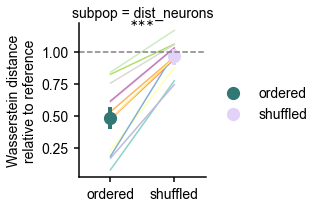

In [18]:
# plot just network as a function of matched/suffled
g = sns.catplot(data=ann_df, x=x, y='test_was_rel', hue=x, palette=x_palette, col=strat, col_order=col_names,
               estimator='mean', scale=1.5, errwidth=4, kind='point', height=3)
g.add_legend()
g.map_dataframe(sns.lineplot, x=x, y='test_was_rel', hue='mouse_name', palette=mouse_colors, errorbar=None, zorder=0)
g.set(xlim=(-.5, 1.5), ylabel='Wasserstein distance\nrelative to reference', xlabel='')
g.refline(y=1.0)
plot_stars(g.axes.flat[0], [0.5], [ann_p])
plt.savefig(f'figs/rel_was{restricted}.pdf')

In [19]:
# do statistics on df (not shuffled)
formula = 'test_was_rel ~ C(code) * C(shuff) * C({})'.format(strat)
model = mixedlm(formula, df, groups='mouse_name')
mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
print(mfit.summary())
result = mfit.summary().tables[1]
relevant_ps = result[1:n_codes]['P>|z|'].values.astype(np.float64)
print(relevant_ps)

                              Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              test_was_rel
No. Observations:              600                  Method:                          REML        
No. Groups:                    12                   Scale:                           0.0132      
Min. group size:               50                   Log-Likelihood:                  397.2740    
Max. group size:               50                   Converged:                       Yes         
Mean group size:               50.0                                                              
-------------------------------------------------------------------------------------------------
                                    Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------------------------------
Intercept                          7.177e-01 3.703

## ED Fig 4l

In [20]:
colors, protocol_info, periods, kwargs = load_params(protocol)
tt_colors = colors['colors']
n_tt = 2

standard_nsplits = 5  # note that this is one less than the julia code, b/c it's counting the number of training sets
test_ind = 1  # second dimension of data is [train, test]
n_transfers = 8
# third and final dimension of data is [wasserstein, relative wasserstein]

data_dir = 'decoding_SameRewDist_pseudo_transfer'
data = np.load(os.path.join(data_dir, 'decoding_SameRewDist_pseudo_transfer_2to3_result_statistics_{}_cutoff_{}.npy'.format(
    protocol, str(cutoff))), allow_pickle=True)
transfer_dists = np.load(os.path.join(data_dir, 'decoding_SameRewDist_pseudo_transfer_2to3_transfer_distributions_{}_cutoff_{}.npy'.format(
    protocol, str(cutoff))), allow_pickle=True)
tts = np.load(os.path.join(data_dir, 'decoding_SameRewDist_pseudo_transfer_2to3_transfer_trials_{}_cutoff_{}.npy'.format(
    protocol, str(cutoff))), allow_pickle=True)
print(data.shape)

(13, 2, 2)


In [21]:
transfer_labels = ['standard', 'matched', 'mismatched']
transfer_type = ['standard'] * 5 + ['matched'] * 4 + ['mismatched'] * 4
ddict = {'wass': data[:, test_ind, :].flatten(),
         'type': np.repeat(transfer_type, 2),
         'rel': np.tile(np.arange(2), len(transfer_type))}
df = pd.DataFrame(ddict)

/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


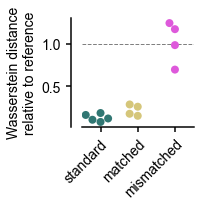

In [22]:
fig, ax = plt.subplots(figsize=(2, 2))
rel_df = df[df['rel'] == 1]
palette = ['#317773ff', '#d5c67aff', '#de59dbff']
sns.swarmplot(rel_df, x='type', y='wass', hue='type', palette=palette, size=8, legend=False)
plt.ylabel('Wasserstein distance\nrelative to reference')
plt.xlabel('')
ax.spines['left'].set_position(("axes", -0.1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.axhline(1, ls='--', color=[.5] * 3, lw=1, zorder=0)
hide_spines()
plt.savefig('figs/transfer_rel.pdf')

In [23]:
rel_df.groupby('type').agg(['mean', 'sem'])

wass            rel     
                mean       sem mean  sem
type                                    
matched     0.216637  0.032358  1.0  0.0
mismatched  1.027729  0.123058  1.0  0.0
standard    0.128441  0.019144  1.0  0.0

In [24]:
for i_lab, lab in enumerate(transfer_labels):
    print(lab, stats.ttest_1samp(rel_df.loc[rel_df['type'] == lab, 'wass'], 1))
    for labj in transfer_labels[i_lab+1:]:
        print(lab, labj, stats.ttest_ind(rel_df.loc[rel_df['type'] == lab, 'wass'],
                                         rel_df.loc[rel_df['type'] == labj, 'wass']))
        diff = rel_df.loc[rel_df['type'] == lab, 'wass'] - rel_df.loc[rel_df['type'] == labj, 'wass']
        print(np.mean(diff))
        print(stats.sem(diff))

standard Ttest_1sampResult(statistic=-45.52735620211858, pvalue=1.392085693374876e-06)
standard matched Ttest_indResult(statistic=-2.4662037738730027, pvalue=0.04307191217066458)
nan
nan
standard mismatched Ttest_indResult(statistic=-8.157435149691176, pvalue=8.046738884597037e-05)
nan
nan
matched Ttest_1sampResult(statistic=-24.209119841943185, pvalue=0.00015448008913959046)
matched mismatched Ttest_indResult(statistic=-6.374430581651612, pvalue=0.000700439118781545)
nan
nan
mismatched Ttest_1sampResult(statistic=0.22533098536584298, pvalue=0.836198964164233)
